# Poisson's equation

Now extend your solver to solve for Poisson's equation.
* Consider a 64 x 64 grids in a domain ($-1<x<1$ and $-1<y<1$)
* Assume $\rho(r)= \exp(-10r)$
* Assume $u$ is zero on the four boundaries.
* Solver for the potential $u$.
* What is the corresponding electrical (or gravitational) field? (Hints: use `numpy.gradient()`)

In [1]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from numba import jit, njit, prange
import matplotlib.pyplot as plt

In [2]:
# Copy your Laplace's Equation solver from demo1 here

def generate_1_4_1_dia(usize=4):
    ex = np.ones(usize)
    data = np.array([-ex, 4 * ex, -ex])
    offsets = np.array([-1, 0, 1])
    A = dia_array((data, offsets), shape=(usize, usize)).toarray()
    return A

def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))
    u   = generate_1_4_1_dia(N)

    d_matrix = generate_1_4_1_dia(N)
    o_matrix = -np.identity(N)
    z_matrix = np.zeros((N,N))

    init_matrix_kernel(N,A,u,d_matrix,o_matrix,z_matrix)
    return A

@njit(parallel=True)
def init_matrix_kernel(N,A,u,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if u[i,j] == 4:
                # the elemen is another 1_4_1 matrix
                suba = d_matrix
            elif u[i,j] == -1:
                suba = o_matrix
            else:
                suba = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = suba[i2,j2]
    return A



def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

The right hand side vector need to be updated when there is a density field $\rho$.
First, we write a function `generate_rho()` to generate the $N \times N$ density field.

In [4]:
def generate_rho(N, xmin=-1, xmax=1, ymin=-1,ymax=1):
    # TODO:
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)

    xx,yy  = np.meshgrid(x,y, indexing='ij')
    radius = np.sqrt(xx**2 + yy**2)
    rho    = np.exp(-10*radius)
    return xx,yy, rho

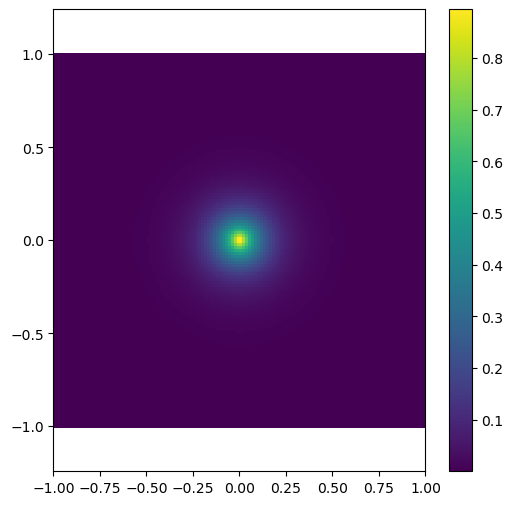

In [7]:
# Visualize the density field
xx,yy, rho = generate_rho(N=128)
plt.figure(1, figsize=(6,6))
plt.pcolormesh(xx,yy,rho)
plt.axis('equal')
plt.colorbar()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Once we have the density filed, we need to modify the `generate_the_rhs_vector_with_size()` to include the density field.

In [8]:
def generate_the_rhs_vector_with_size(N=4, rho=None, dx=1):

    if rho is None:
        b = np.zeros(N*N)
        b[-N:] = 1
    else:
        b = rho.flatten()
        b = -b * dx**2
        b[-N:] += 0 # if there are some BC

    return b

We could solve the system by the same way in `solve_laplace()`.

In [12]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)
    xx,yy, rho = generate_rho(N=N, xmin=-1, xmax=1, ymin=-1,ymax=1)
    b = generate_the_rhs_vector_with_size(N=N, rho=rho, dx=2/(N-1))
    #x = linalg.solve(A,b) # use scipy
    #x = lu_solve(A,b)      # use our solver
    x = splinalg.spsolve(A,b) # use scipy sparse solver
    u = convert_solution(x)
    return xx,yy, u

In [13]:
xx,yy, u = solve_laplace(N=128)

/var/folders/4k/42fcl0t94l52cvs1kllf176r0000gn/T/ipykernel_38665/1196291758.py:7: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = splinalg.spsolve(A,b) # use scipy sparse solver


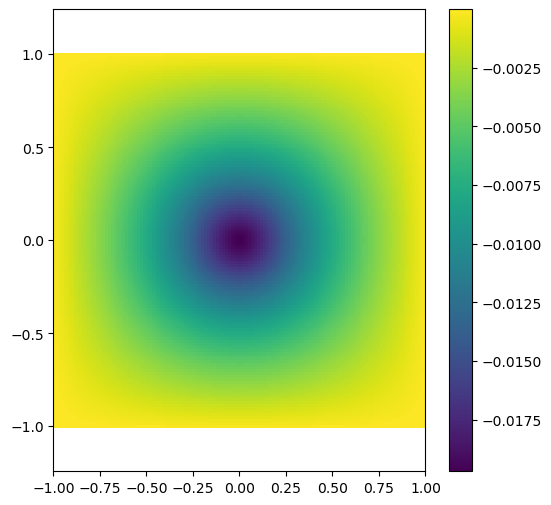

In [15]:
# Visualize the solution
plt.figure(2, figsize=(6,6))
plt.pcolormesh(xx,yy,u)
plt.colorbar()
#plt.contour(xx,yy, u,10, colors="w")
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Calculate the gravitational field

In [ ]:
phi =np.gradient(u)

In [ ]:
plt.imshow(phi[0]) # x derivative

In [ ]:
plt.imshow(phi[1]) # y derivative